<a href="https://colab.research.google.com/github/nickhward/Tweets_and_bitcoin/blob/main/Bitcoin_tweet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Training / Inference NoteBook**

This notebook will train a model on the sentiment analysis of the cleaned bitcoin text, the users followed will have more or less weight bassed on the ammount of followers as more followers most likely will have more influence. 


The target value will be the percent change of the next series of the month, week, or day. I don't want to do exact prices as that is much to volitile to accurately predict. But if there is a lag in the tweets and prices I will find it!


In [1]:
import pandas as pd

In [2]:
# Uploading the tweet data
df_tweets = pd.read_csv('/content/drive/MyDrive/cleaned_bitcoin_tweet_data.csv')
df_tweets.head()

,Unnamed: 0,user_followers,user_friends,user_verified,date,text,text_no_stop,cleaned_text,is_english,pos,neu,neg,compound
0,0,8534.0,7605.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after bi...,Blue Ridge Bank shares halted by NYSE after bi...,Blue Ridge Bank shares halted by NYSE after bi...,True,0.145,0.855,0.0,0.2960
1,1,6769.0,1532.0,False,2021-02-10 23:58:48,Today thats this Thursday we will do a Take ...,Today thats this Thursday we will do a Take 2 ...,Today thats this Thursday we will do a Take 2 ...,True,0.248,0.752,0.0,0.6808
2,9,8534.0,7605.0,False,2021-02-10 23:52:08,Teslas bitcoin investment is revolutionary for...,Teslas bitcoin investment is revolutionary for...,Teslas bitcoin investment is revolutionary for...,True,0.000,1.000,0.0,0.0000
3,12,5097.0,791.0,False,2021-02-10 23:50:59,Join our first virtual crypto meetup of 2021 ...,Join our first virtual crypto meetup of 2021 C...,Join our first virtual crypto meetup of 2021 C...,True,0.109,0.891,0.0,0.2960
4,16,72542.0,519.0,False,2021-02-10 23:48:37,naval BTC is unconfiscatable \n\nAll roads lea...,naval BTC is unconfiscatable All roads lead to...,naval BTC is unconfiscatable All roads lead to...,True,0.000,1.000,0.0,0.0000


In [3]:
# i need to see where the dates will line up with
earliest_date = df_tweets['date'].min()
latest_date = df_tweets['date'].max()

print(f"Earliest Date: {earliest_date}")
print(f"Latest Date: {latest_date}")

Earliest Date: 2021-02-05 10:58:47
Latest Date: 2023-01-09 23:59:32


In [4]:
# Uploading daily bitcoin data

df_bitcoin = pd.read_csv('/content/drive/MyDrive/BTCUSD_Daily.csv', sep='\t')

df_bitcoin = df_bitcoin.rename(columns={'<DATE>': 'Date', '<CLOSE>': 'Close'})
df_bitcoin.head()

,Date,<OPEN>,<HIGH>,<LOW>,Close,<TICKVOL>,<VOL>,<SPREAD>
0,2021.02.05,37658.08,38342.56,36592.64,37854.25,1065024,0,0
1,2021.02.06,37845.90,40993.56,37701.50,40068.56,1025050,0,0
2,2021.02.07,40060.45,40494.33,37357.51,38588.56,1197337,0,0
3,2021.02.08,38580.49,44862.57,38042.46,44698.09,1185244,0,0
4,2021.02.09,44664.05,48185.76,44270.01,47323.61,1408809,0,0


In [5]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'])
df_tweets.set_index('date', inplace=True)

df_bitcoin['Date'] = pd.to_datetime(df_bitcoin['Date'])
df_bitcoin.set_index('Date', inplace=True)

In [6]:
btc_weekly = df_bitcoin.resample('W').last()
btc_weekly.head(20)
# Calculate percent change in price for each month
btc_weekly['price_pct_change'] = btc_weekly['Close'].pct_change()

#to make less clusterd I will be dropping some un wanted columns
COLUMNS_TO_DROP = ['<OPEN>', '<HIGH>', '<LOW>', '<TICKVOL>', '<VOL>', '<SPREAD>']
btc_weekly = btc_weekly.drop(columns=COLUMNS_TO_DROP)
btc_weekly.head()

,Close,price_pct_change
Date,,
2021-02-07,38588.56,NaN
2021-02-14,48859.50,0.266165
2021-02-21,57333.96,0.173445
2021-02-28,45218.75,-0.211309
2021-03-07,50063.95,0.107150


Lets see if there is any correlation between the percent change at the end of the next week. I'm going to go off of sentiment of the whole month, then what the weeks percent change looks like. 

In [7]:
#resample for monthly data and get the means of impoortant data points
tweet_monthly = df_tweets.resample('M').agg({'compound':'mean', 'pos' : 'mean', 'user_followers' : 'mean', 'neg' : 'mean'})
tweet_monthly.head()

,compound,pos,user_followers,neg
date,,,,
2021-02-28,0.160868,0.085750,40462.601689,0.020268
2021-03-31,0.123002,0.083435,38640.132812,0.024589
2021-04-30,0.125204,0.059491,27166.421224,0.018139
2021-05-31,0.103460,0.057238,24334.206061,0.022512
2021-06-30,0.176140,0.090170,71753.814837,0.036840


In [8]:
btc_weekly_shifted = btc_weekly.shift(-4) # 4 weeks for a month

# This fills the weekly rows with the corresponding monthly value
tweet_monthly = tweet_monthly.reindex(btc_weekly_shifted.index, method='pad') 

combined_df = pd.concat([tweet_monthly, btc_weekly_shifted], axis=1)
combined_df = combined_df.dropna() # Remove any rows with missing values
combined_df.head()

,compound,pos,user_followers,neg,Close,price_pct_change
Date,,,,,,
2021-02-28,0.160868,0.08575,40462.601689,0.020268,54807.18,-0.051694
2021-03-07,0.160868,0.08575,40462.601689,0.020268,58030.79,0.058817
2021-03-14,0.160868,0.08575,40462.601689,0.020268,59661.00,0.028092
2021-03-21,0.160868,0.08575,40462.601689,0.020268,56252.23,-0.057136
2021-03-28,0.160868,0.08575,40462.601689,0.020268,48075.08,-0.145366


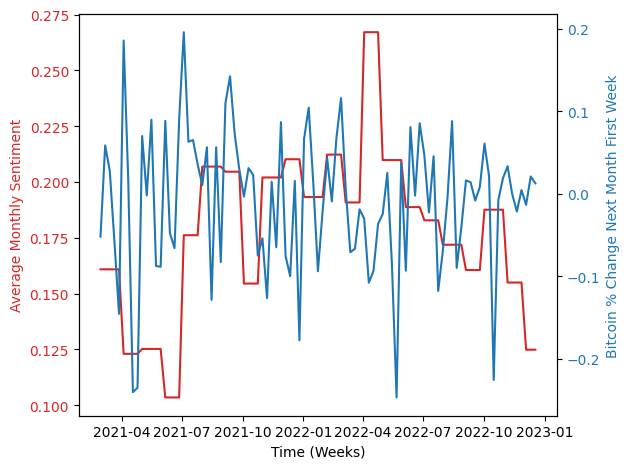

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time (Weeks)')
ax1.set_ylabel('Average Monthly Sentiment', color=color)
ax1.plot(combined_df.index, combined_df['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Bitcoin % Change Next Month First Week', color=color)
ax2.plot(combined_df.index, combined_df['price_pct_change'], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.show()

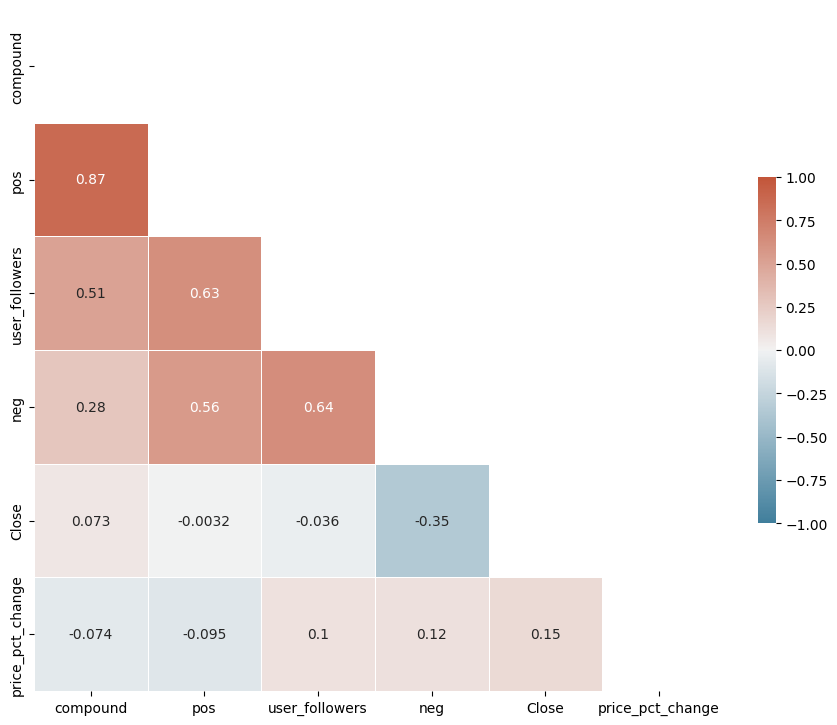

In [10]:
import seaborn as sns
import numpy as np
# Calculate correlation matrix
corr = combined_df.corr()

# Generate a mask for the upper triangle (optional, this is just for aesthetics)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

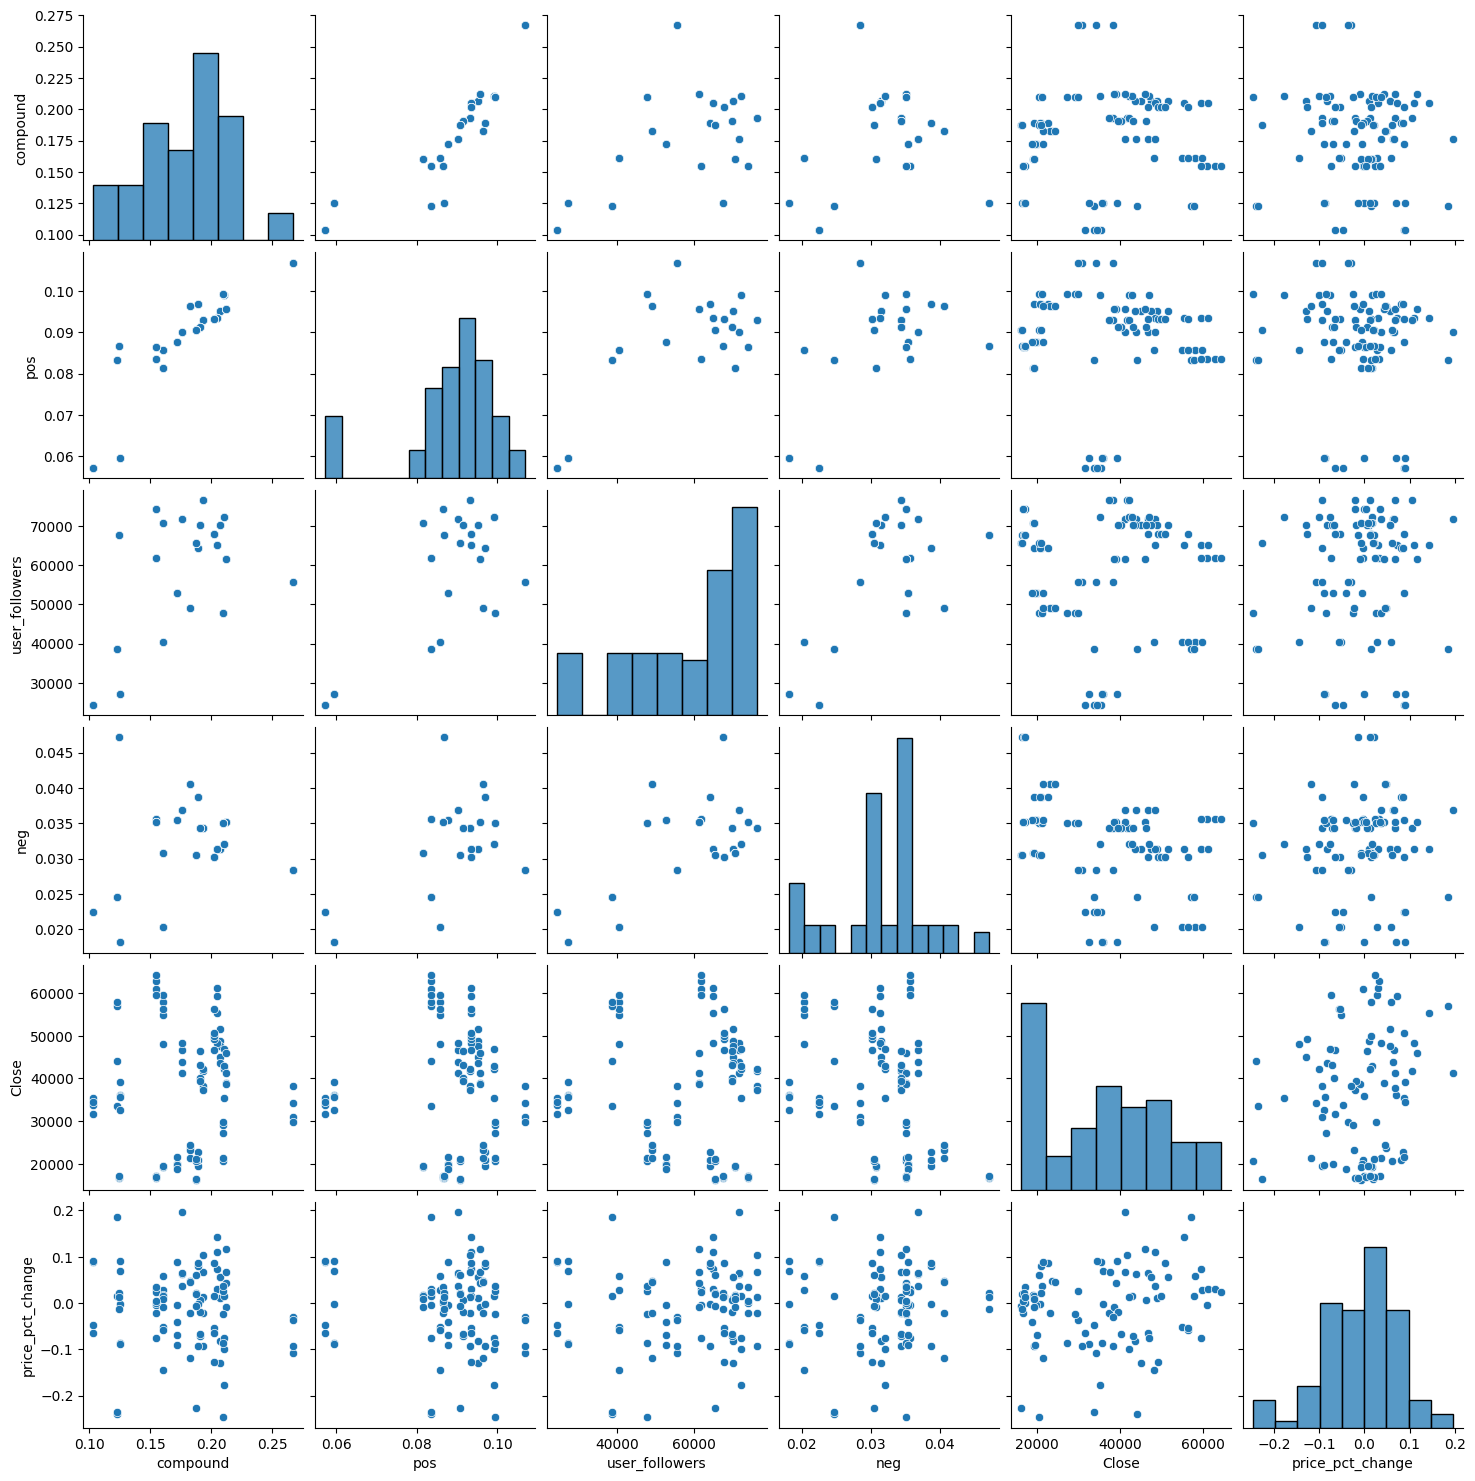

In [11]:
sns.pairplot(combined_df)
plt.show()

In [12]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#creating a baseline model to see what happens.
from xgboost import XGBRegressor

y = combined_df.pop('price_pct_change')

combined_df = combined_df.drop('Close', axis=1)
X = combined_df

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

clf = XGBRegressor()

clf.fit(X_train, y_train)
# Assuming y_test are your true target values and y_pred are the predicted values
y_pred = clf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)

MAE:  0.05401354564020028


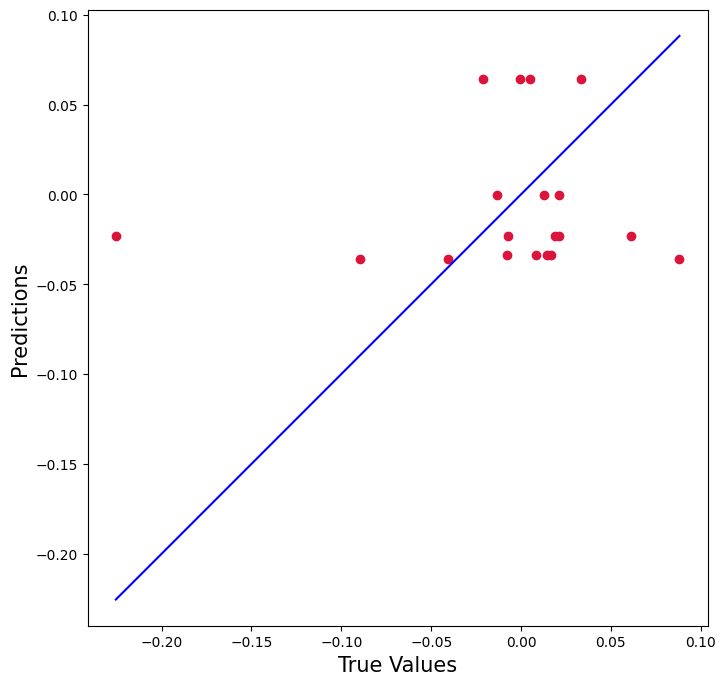

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, c='crimson')


p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

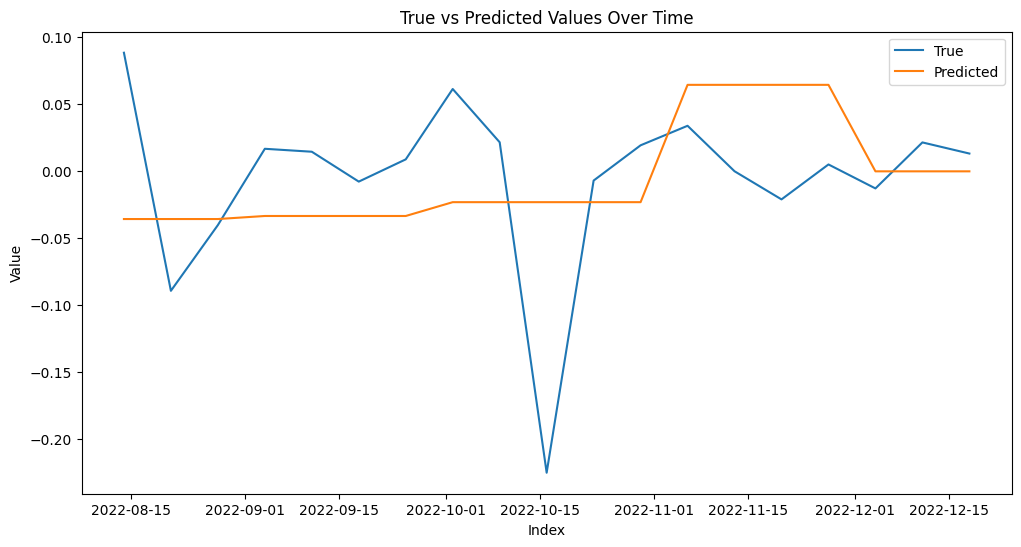

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predicted') # Note: use y_test.index for x-axis to ensure same length
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values Over Time')
plt.legend()
plt.show()

The above xgboost was a baseline model test. I realistically want to use a model that does well with sequential data like my own.

The next step is going to be utilizing a transformer.

But first I must set up the data correctly.



In [21]:
from tqdm import tqdm

sequence_start_indices = []
target_indices = []
btc_daily_pct_change = df_bitcoin['Close'].pct_change()
btc_weekly_pct_change = btc_daily_pct_change.resample('W').sum()


# We'll start our first sequence at the first day we have data for
current_start_index = 0
days_in_week = 7
days_in_month = 30
#df_tweets = df_tweets.drop(columns=['Unnamed: 0', 'user_verified', 'text', 'text_no_stop', 'cleaned_text', 'is_english'])

df_tweets_daily = df_tweets.groupby(pd.Grouper(freq='D')).agg(list)

columns_of_interest = ['compound', 'pos', 'user_followers', 'neg']
sequences = []
targets = []

# Calculate the maximum index for the sliding window
max_index = len(df_tweets_daily) - days_in_month - days_in_week

# Continue until we don't have a full week of targets left after a month-long sequence
for current_start_index in tqdm(range(max_index+1), desc='Generating indices'):
    
    # Append the sequence of tweets from 30 consecutive days
    sequences.append(df_tweets_daily[columns_of_interest].iloc[current_start_index:current_start_index+days_in_month].values)
    
    # Append the target, which is the Bitcoin percent change during the week starting 30 days later
    targets.append(btc_weekly_pct_change.iloc[current_start_index+days_in_month:current_start_index+days_in_month+days_in_week].sum())

Generating indices: 100%|██████████| 668/668 [00:00<00:00, 1135.35it/s]


In [31]:
print(sequences[667])

[[list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([]) list([]) list([]) list([])]
 [list([0.0, -0.5994, 0.5423, 0.5423, 0.0, 0.0, 0.0, -0.694, 0.875, 0.2716, 0.0, -0.5574, 0.7783, -0.4019, 0.5473, 0.5904, 0.0, 0.0, 0.0, 0.0, -0.6486, -0.34, 0.7269, -0.6486, -0.4466, -0.1531, 0.2732, 0.5994, -0.1513, 0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the split point: 80% of the length of the sequences
split_point = int(len(sequences) * 0.8)

# Split sequences
train_sequences = sequences[:split_point]
test_sequences = sequences[split_point:]

# Split targets
train_targets = targets[:split_point]
test_targets = targets[split_point:]

# Pad sequences
train_sequences_padded = pad_sequences(train_sequences, dtype='float32', padding='post')
test_sequences_padded = pad_sequences(test_sequences, dtype='float32', padding='post')


n_in = train_sequences_padded.shape[1]  # number of steps in each sequence
n_features = train_sequences_padded.shape[2]  # number of features in each step


In [ ]:
# Convert targets to numpy arrays
train_targets = np.array(train_targets)
test_targets = np.array(test_targets)

# Define encoder
encoder_inputs = Input(shape=(n_in, n_features))
encoder_lstm = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Define decoder
decoder_inputs = RepeatVector(n_in)(encoder_outputs)
decoder_lstm = LSTM(100, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(1))
decoder_outputs = decoder_dense(decoder_outputs)

# Create model
model = Model(encoder_inputs, decoder_outputs)

# Compile model
model.compile(optimizer='adam', loss='mae')

In [ ]:
history = model.fit(train_sequences_padded, train_targets, epochs=10, batch_size=32, validation_split=0.2)
predictions = model.predict(test_sequences_padded)




In [ ]:
predictions_last = predictions[:, -1, :]
mae = mean_absolute_error(test_targets, predictions_last)
print('Mean Absolute Error:', mae)

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(test_targets, label='Actual')

# Plot the predicted values
plt.plot(predictions_last, label='Predicted')

# Add a legend
plt.legend()

# Show the plot
plt.show()

print(predictions)
print(predictions_last)


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
print(len(targets))